**Content**

- Resampling Techs for Imbalanced Datasets

- Python `imbalanced-learn` Package 

- Illustration for Resampling Methods 
    - **Undersampling Techniques**
        1. Random Undersampling
        2. Tomek Links
        3. ENN (Edited Nearest Neighbours)

    - **Oversampling Techniques**
        1. Random Oversampling
        2. SMOTE (Synthetic Minority Over-Sampling Technique)
        3. ADASYN (Adaptive Synthetic Sampling)
    
    - **Combined Resampling**
        1. SMOTETomek
        2. SMOTEENN

- Case Study of Imbalance Data: Bank Marketing
    - Tidy Data
        1. Check missing
        2. Get X and y
        3. Check imbalance
        4. Transformation on X and y

    - The Metric Trap

    - Confusion Matrix

    - Apply Resampling

- Recommand Reading


In [1]:
# data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

# Resampling Techs for Imbalanced Datasets

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](resampling_img.png)

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

**NOTE**
- When use any resampling technique, we must split the data as training and testing first and then apply resampling on the training data only. After we fit a machine learning model, we then use the testing set (which contains only original samples) to evaluate. 


# Python `imbalanced-learn` Package 

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library [imbalanced-learn](https://imbalanced-learn.org/stable/). It is compatible with `scikit-learn` and is part of `scikit-learn-contrib` projects.



In [2]:
from imblearn import under_sampling, over_sampling, combine

Using TensorFlow backend.


The sampling techniques in `imblearn` could be classified as three groups: `Undersampling`, `Oversampling`, and `Combined Resampling`. In each group, there are several different methods to do the sampling. In this notebook, I will go through some of widely-used methods in each group:

- **Undersampling Techniques**
    1. Random Undersampling
    2. Tomek Links
    3. ENN (Edited Nearest Neighbours)

- **Oversampling Techniques**
    1. Random Oversampling
    2. SMOTE (Synthetic Minority Over-Sampling Technique)
    3. ADASYN (Adaptive Synthetic Sampling)
    

- **Combined Resampling**
    1. SMOTETomek
    2. SMOTEENN

# Illustration for Resampling Methods 

Next, I will make up a small unbalanced dataset to illustrate the above methods. This unbalanced dataset has 1000 data points with 2 features. The target value is binary (0 and 1). 

In [3]:
from sklearn.datasets import make_classification

X_org, y_org = make_classification(n_classes=3, n_features=2, n_clusters_per_class=1,
                                   class_sep=0.7, weights=(0.7, 0.2, 0.1),
                                   n_informative=2, n_redundant=0, flip_y=0,
                                   n_samples=1000, random_state=123)

df_org = pd.DataFrame(X_org)
df_org['target'] = y_org

In [4]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


The following function will be used to plot the sample space.

In [5]:
from collections import Counter

def plot_2d_space(X, y, ax, title=None):
    
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha = 0.8, edgecolor='k')

    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    ax.add_artist(legend) 
    if title:
        y_counter = Counter(y)
        ax.set_title('{}\n with y={}'.format(title, dict(y_counter)))

Look at the original data

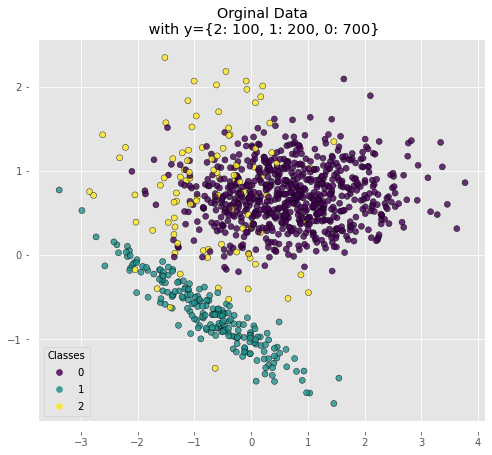

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))

plot_2d_space(X=X_org, y=y_org, ax=ax, title="Orginal Data")

fig.show()
fig.savefig('org_data.png', format='png', dpi=150)

## Undersampling

### Undersampling: Naive Random

The simplest form of undersampling is to remove random records from the majority class. With `imblearn` we can choose to remove samples with or without replacement. The biggest drawback to this form of undersampling is loss of information.

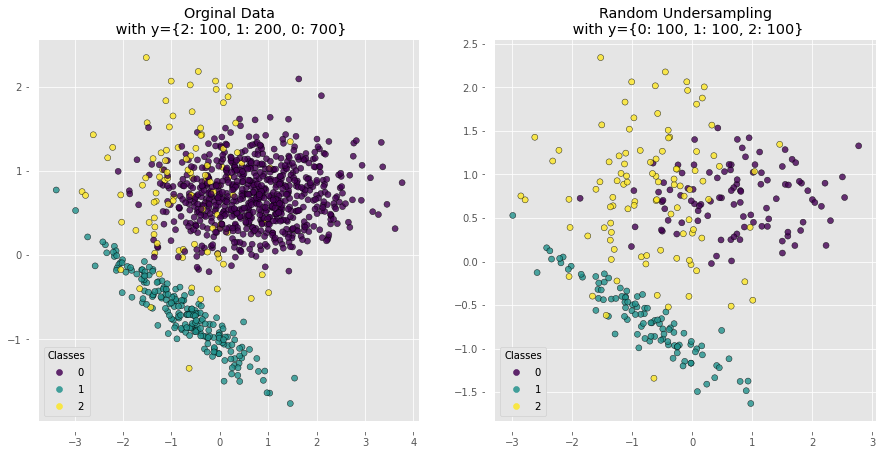

In [40]:
random_us = under_sampling.RandomUnderSampler(random_state=123, replacement=False)

X_random_us, y_random_us = random_us.fit_resample(X_org, y_org)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

plot_2d_space(X=X_org, y=y_org, ax=ax1, title="Orginal Data")
plot_2d_space(X=X_random_us, y=y_random_us, ax=ax2, title="Random Undersampling")

fig.show()
fig.savefig('org_vs_random_under.png', format='png', dpi=150)

### Undersampling: Tomek Links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](tomeklink_img.png)

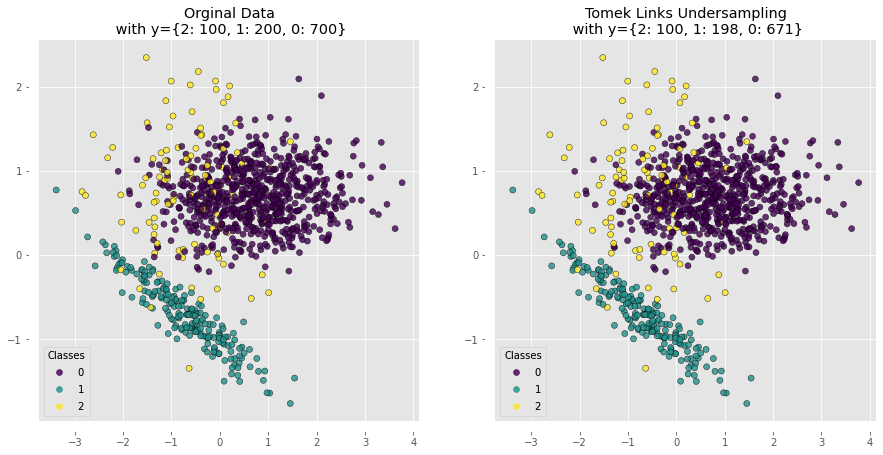

In [41]:
tomek_us = under_sampling.TomekLinks(random_state=123)

X_tomek_us, y_tomek_us = tomek_us.fit_resample(X_org, y_org)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

plot_2d_space(X=X_org, y=y_org, ax=ax1, title="Orginal Data")
plot_2d_space(X=X_tomek_us, y=y_tomek_us, ax=ax2, title="Tomek Links Undersampling")

fig.show()
fig.savefig('org_vs_tomek_under.png', format='png', dpi=150)

### Undersampling: ENN (Edited Nearest Neighbours)

ENN applies a nearest-neighbors algorithm and "edit" the dataset by removing samples which do not agree “enough” with their neighboorhood. For each sample in the class to be under-sampled, the nearest-neighbours are computed and if the selection criterion is not fulfilled, the sample is removed. Two selection criteria are currently available: (i) the majority (i.e., `kind_sel='mode'`) or (ii) all (i.e., `kind_sel='all'`) the nearest-neighbors have to belong to the same class than the sample inspected to keep it in the dataset:


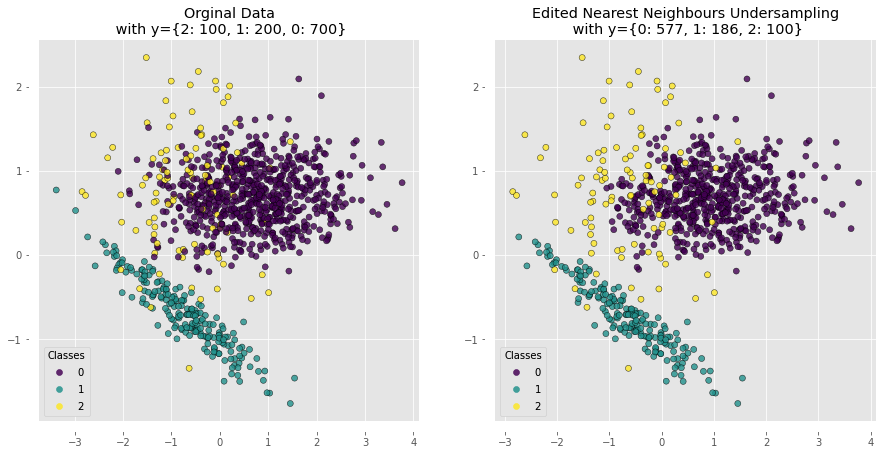

In [42]:
enn_us = under_sampling.EditedNearestNeighbours(random_state=123,
                                                n_neighbors=3,
                                                kind_sel='all')

X_enn_us, y_enn_us = enn_us.fit_resample(X_org, y_org)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

plot_2d_space(X=X_org, y=y_org, ax=ax1, title="Orginal Data")
plot_2d_space(X=X_enn_us, y=y_enn_us, ax=ax2, title="Edited Nearest Neighbours Undersampling")

fig.show()
fig.savefig('org_vs_enn_under.png', format='png', dpi=150)

## Oversampling

### Oversampling: Naive Random

The simplest implementation of oversampling is to duplicate random records from the minority class, this can cause overfitting.

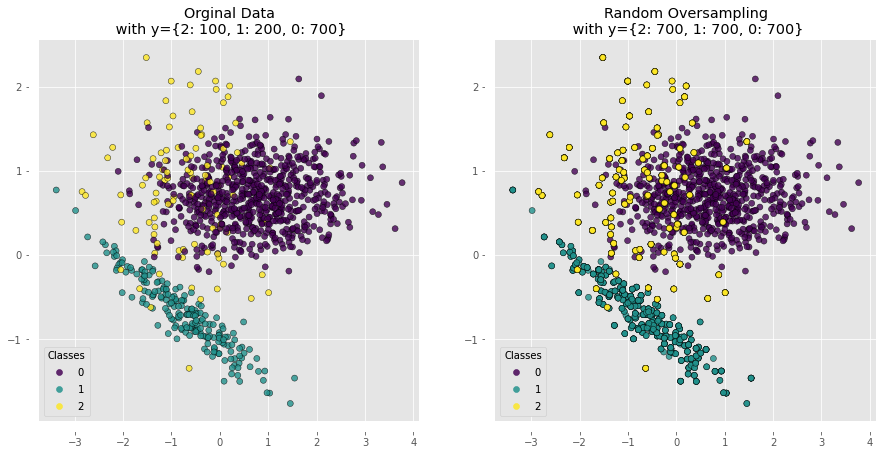

In [43]:
random_os = over_sampling.RandomOverSampler(random_state=123)

X_random_os, y_random_os = random_os.fit_resample(X_org, y_org)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

plot_2d_space(X=X_org, y=y_org, ax=ax1, title="Orginal Data")
plot_2d_space(X=X_random_os, y=y_random_os, ax=ax2, title="Random Oversampling")

fig.show()
fig.savefig('org_vs_random_over.png', format='png', dpi=150)

### Oversampling: SMOTE (Synthetic Minority Oversampling TEchnique)

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![](smote_img.png)

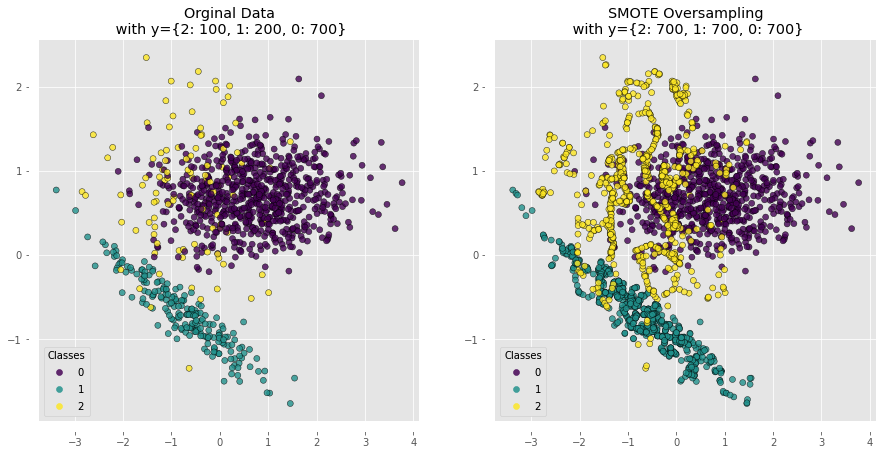

In [48]:
smote_os = over_sampling.SMOTE(k_neighbors=5, random_state=123)

X_smote_os, y_smote_os = smote_os.fit_resample(X_org, y_org)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

plot_2d_space(X=X_org, y=y_org, ax=ax1, title="Orginal Data")
plot_2d_space(X=X_smote_os, y=y_smote_os, ax=ax2, title="SMOTE Oversampling")

fig.show()
fig.savefig('org_vs_smote_over.png', format='png', dpi=150)

### Oversampling: ADASYN (Adaptive Synthetic Sampling)

Both SMOTE and ADASYN generate new samples in by interpolation. However, the samples used to interpolate/generate new synthetic samples differ. In fact, ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier while the basic implementation of SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule. 

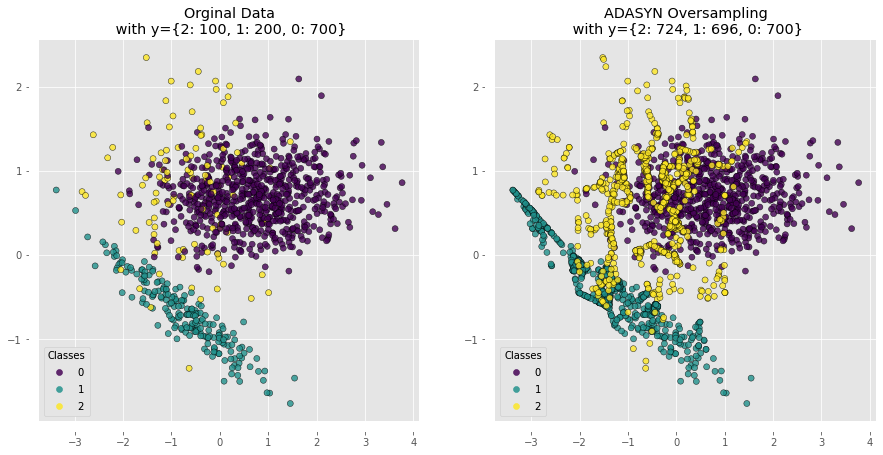

In [49]:
adasyn_os = over_sampling.ADASYN(n_neighbors=5, random_state=123)

X_adasyn_os, y_adasyn_os = adasyn_os.fit_resample(X_org, y_org)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

plot_2d_space(X=X_org, y=y_org, ax=ax1, title="Orginal Data")
plot_2d_space(X=X_adasyn_os, y=y_adasyn_os, ax=ax2, title="ADASYN Oversampling")

fig.show()
fig.savefig('org_vs_adasyn_over.png', format='png', dpi=150)

## Combined Sampling

### Combined Sampling: SMOTETomek

SMOTETomek is the combination of using Tomek links to undersample the majoirty class and the use of SMOTE to oversample the minority class.

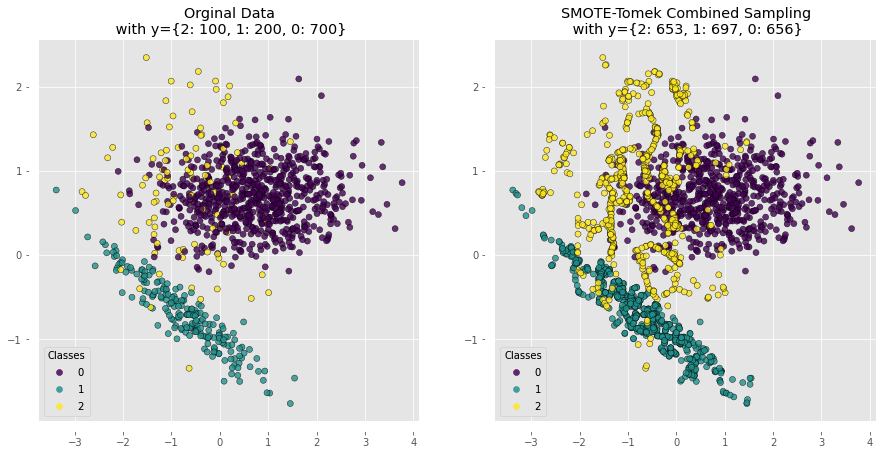

In [50]:
smote_tomek_cs = combine.SMOTETomek(random_state=123)

X_smote_tomek_cs, y_smote_tomek_cs = smote_tomek_cs.fit_resample(X_org, y_org)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

plot_2d_space(X=X_org, y=y_org, ax=ax1, title="Orginal Data")
plot_2d_space(X=X_smote_tomek_cs, y=y_smote_tomek_cs, ax=ax2, title="SMOTE-Tomek Combined Sampling")

fig.show()
fig.savefig('org_vs_smote-tomek_over.png', format='png', dpi=150)

### Combined Sampling: SMOTEENN

SMOTEENN is the combination of SMOTE and Edited Nearest Neighbor. ENN removes any example whose class label differs from the class label of at least two of its three nearest neighbors. ENN tends to remove more examples then the Tomek links.

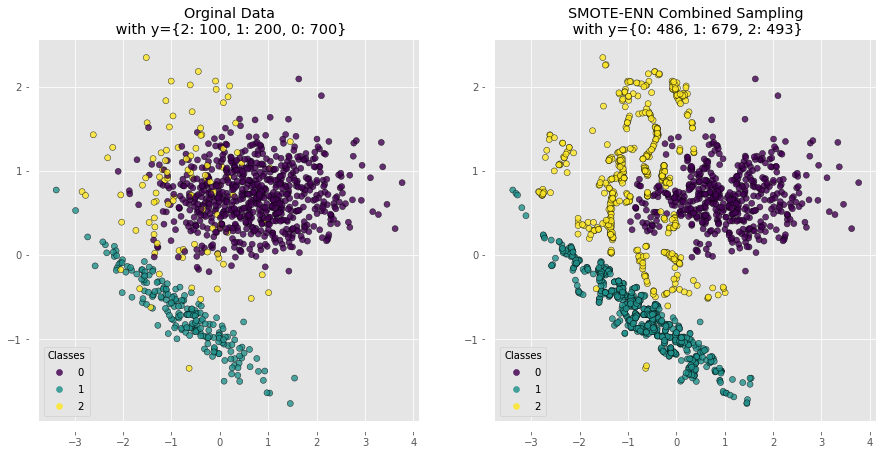

In [51]:
smote_enn_cs = combine.SMOTEENN(random_state=123)

X_smote_enn_cs, y_smote_enn_cs = smote_enn_cs.fit_resample(X_org, y_org)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

plot_2d_space(X=X_org, y=y_org, ax=ax1, title="Orginal Data")
plot_2d_space(X=X_smote_enn_cs, y=y_smote_enn_cs, ax=ax2, title="SMOTE-ENN Combined Sampling")

fig.show()
fig.savefig('org_vs_smote-enn_over.png', format='png', dpi=150)

# Case Study of Imbalance Data: Bank Marketing

**Bank Marketing** data is highly imbalanced. 

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

**Data Set Information**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

**Attribute Information**

- Bank client data:
    - Age (numeric)
    
    - Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')

    - Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)

    - Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')

    - Default: has credit in default? (categorical: 'no', 'yes', 'unknown')

    - Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')

    - Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

- Related with the last contact of the current campaign:
    - Contact: contact communication type (categorical: 'cellular','telephone')

    - Month: last contact month of year (categorical: 'jan', 'feb', 'mar', ... , 'nov', 'dec')

    - Dayofweek: last contact day of the week (categorical:'mon','tue','wed','thu','fri')

    - Duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

- Other attributes:
    - Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    - Pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    - Previous: number of contacts performed before this campaign and for this client (numeric)
    - Poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

- Social and economic context attributes
    - Emp.var.rate: employment variation rate - quarterly indicator (numeric)
    - Cons.price.idx: consumer price index - monthly indicator (numeric)
    - Cons.conf.idx: consumer confidence index - monthly indicator (numeric)
    - Euribor3m: euribor 3 month rate - daily indicator (numeric)
    - Nr.employed: number of employees - quarterly indicator (numeric)

- Output variable (desired target):
    - y: has the client subscribed a term deposit? (binary: 'yes', 'no')

In [15]:
# Load data
initial_data = pd.read_csv('../data/UCI-machine-learning-repository/bank-marketing/bank-additional-full.csv', 
                            sep=";")

# information of the data: 41188 data points, 20 features' columns and 1 target column
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [16]:
initial_data.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

## Tidy Data

### Check missing

First, we should check if there are missing values in the dataset. In the raw data, the value "unknown" indicates that there is no such values. Then, we could replace all "unknown" as `np.nan` and drop the associated rows. 

In [17]:
initial_data.replace("unknown", np.nan, inplace=True)

In [18]:
# check if there are Null values
initial_data.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. Actually, there exists some strategies to impute missing values (see [here](https://scikit-learn.org/stable/modules/impute.html)). For simplicity, we will discard the rows with missing values. 

In [19]:
# Discard the rows with missing values
data_to_use = initial_data.dropna()

# Shape of the data: we could see that the number of rows is 30488 now (originally it is 41188)
data_to_use.shape

(30488, 21)

### Get X and y

For simplicity, we only use a set of features related to Bank client data: `age`, `job`, `marital`, `education`, `default`, `housing`, and `loan`. 

In [20]:
X = data_to_use[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']].copy() # X is a dataframe

y = data_to_use['y'].values # y is an array

### Check Imbalance

In [21]:
# Calculate Y ratio
def data_ratio(y):
    '''
    Calculate Y's ratio
    '''
    unique, count = np.unique(y, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

The class ratio for the original data: 6.9:1 (26629/3859)


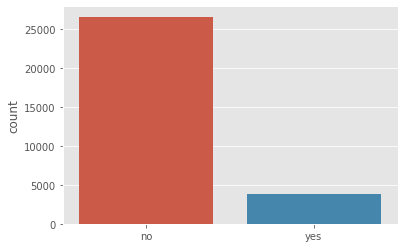

In [22]:
print('The class ratio for the original data:', data_ratio(y))
sns.countplot(y,label="Sum")
plt.show()

We could see that the dataset is highly imbalanced. About 87% records are "no", only 13% records are "yes" 

### Transformation on X and y

- Split X and y as X_train, X_test, y_train, y_test
- Check numerical and categorical columns
- Transformation on X: Perform `OneHotEncoder` on categorical columns.
- Transformation on y: Perform `LabelEncoder` on y.


In [23]:
# sklearn: data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
# sklearn: train model
from sklearn.model_selection import train_test_split

# Split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# check categorical and numerical columns
# determine categorical and numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [24]:
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')

In [25]:
numerical_cols

Index(['age'], dtype='object')

In [26]:
# Define the transformation methods for the columns
t = [('ohe', OneHotEncoder(drop='first'), categorical_cols)]

# Feed the transformation methods into ColumnTransformer
col_trans = ColumnTransformer(transformers=t, remainder="passthrough")

# fit the transformation on training data
col_trans.fit(X_train)

# apply transformation to both training and testing data 
X_train_transform = col_trans.transform(X_train)
X_test_transform = col_trans.transform(X_test)

# Define a LabelEncoder() transformation method and fit on y_train
target_trans = LabelEncoder()
target_trans.fit(y_train)

# apply transformation method on y_train and y_test
y_train_transform = target_trans.transform(y_train)
y_test_transform = target_trans.transform(y_test)

Note that the original column names and column orders have been modified.

Let's define a function called `get_column_names_from_ColumnTransformer`, which is used to recover the new columns' names and orders after `ColumnTransformer`.

In [27]:
from sklearn.pipeline import Pipeline

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
        
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]

        if isinstance(transformer_in_columns[1], Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        
        try:
            names = transformer.get_feature_names(input_features=raw_col_name)
        
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            
            if transformer_in_columns[1] == "passthrough":
                names = column_transformer._feature_names_in[raw_col_name]
            else:
                names = raw_col_name

        if isinstance(names,np.ndarray): 
            col_name += names.tolist()
        
        elif isinstance(names,pd.Index): 
            col_name += names.tolist()
        
        elif isinstance(names,list):
            col_name += names    

        elif isinstance(names,str):
            col_name.append(names)

    return col_name

In [28]:
new_cols_names = get_column_names_from_ColumnTransformer(col_trans)

new_cols_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_married',
 'marital_single',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'age']

## The Metric Trap

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like `accuracy_score` can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

For example, in our hold-out testing data, if we predict all "No", we will still have 87% accuracy. 

The class ratio for the hold-out testing data: 6.8:1 (7981/1166)


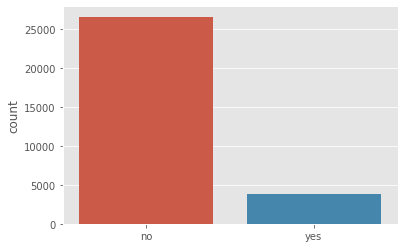

In [29]:
print('The class ratio for the hold-out testing data:', data_ratio(y_test_transform))
sns.countplot(y,label="Sum")
plt.show()

If we still use `accuracy` as the evaluation metric for machine learning model, high accuracy is misleading!

Let's look at the following experiment for training RandomForest model.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


clf = RandomForestClassifier(random_state=123)
clf.fit(X_train_transform, y_train_transform)

y_pred = clf.predict(X_test_transform)

accuracy = accuracy_score(y_test_transform, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.44%


As we can see, the high accuracy rate was just an illusion. In this way, the choice of the metric used in unbalanced datasets is extremely important. 

## Confusion matrix

An good way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class. 

The following function is used to plot the confusion matrix.

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax,
                          class_names=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Confusion Matrix (Normalized)'
        else:
            title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if class_names:
        class_names = np.array(class_names)
        class_names = class_names[unique_labels(y_true, y_pred)]
    else:
        class_names = unique_labels(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, 
           yticklabels=class_names,
           title=title,
           ylabel='True class',
           xlabel='Predicted class')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that 91% class 1 entries were erroneously predicted as class 0.

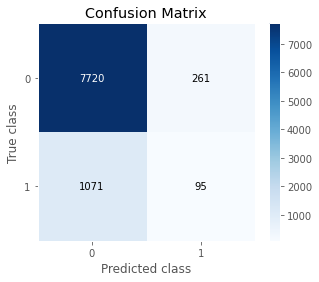

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

plot_confusion_matrix(y_true=y_test_transform, y_pred=y_pred, ax=ax)

fig.show()

According to the confusion matrix, we could calculate additional metrics such as `precision`, `recall`, `f1-score`, etc. In our case, we are interested in predicting if the client will subscribe a term deposit. Specifically, we are expecting that the ideal model has the ability to precisly predict and capture those clients who will subscribe a deposit. In other words, we want our model have relatively high precision and recall on `y=1`. Therefore, `f1` score would be a our evaluation metric, which taking both precision and recall into consideration. If `f1` is close to 1, it indicates good model.  

In [33]:
print(classification_report(y_true=y_test_transform, y_pred=y_pred))

precision    recall  f1-score   support

           0       0.88      0.97      0.92      7981
           1       0.27      0.08      0.12      1166

    accuracy                           0.85      9147
   macro avg       0.57      0.52      0.52      9147
weighted avg       0.80      0.85      0.82      9147



## Apply Resampling

According to the above confusion matrix, we could see that the RandomForest model is hard to "capture" tagert `y=1` (`recall = 8%`) and it has bad precision on predicting `y=1` (`precision = 27%`).

Next, I will apply one resampling method (`SMOTETomek`) on the training data and train RandomForest model again, then evaluate it on hold-out testing data to check if the resampling methods have improvements on predicitons.

**NOTE**

When use any resampling technique, we must split the data as training and testing first and then apply resampling on the training data only. After we fit a machine learning model, we then use the testing set (which contains only original samples) to evaluate. 


In [34]:
smote_tomek_cs = combine.SMOTETomek(random_state=123)

X_resample, y_resample = smote_tomek_cs.fit_resample(X_train_transform, y_train_transform)

In [35]:
clf_new = RandomForestClassifier(random_state=123)
clf_new.fit(X_resample, y_resample)

y_pred_new = clf_new.predict(X_test_transform)

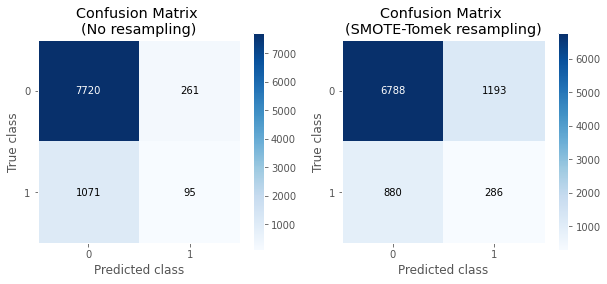

In [55]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

plot_confusion_matrix(y_true=y_test_transform, y_pred=y_pred, ax=ax1, 
                      title="Confusion Matrix \n(No resampling)")

plot_confusion_matrix(y_true=y_test_transform, y_pred=y_pred_new, ax=ax2, 
                      title="Confusion Matrix \n(SMOTE-Tomek resampling)")

fig.show()

In [37]:
print(classification_report(y_true=y_test_transform, y_pred=y_pred_new))

precision    recall  f1-score   support

           0       0.89      0.85      0.87      7981
           1       0.19      0.25      0.22      1166

    accuracy                           0.77      9147
   macro avg       0.54      0.55      0.54      9147
weighted avg       0.80      0.77      0.78      9147



Clearly, the ability of capturing `y=1` increases from `recall = 8%` to `recall = 25%`, while the precision for `y=1` decreases to 19%. If we look at the selected metric `f1` score, we could see that `f1` score increases from 0.12 to 0.22, which shows that the `SMOTE-Tomek` oversampling method improves the model's prediction ability. 



# Recommended Reading

The imbalanced-learn documentation:<br>
https://imbalanced-learn.org/stable/index.html

The imbalanced-learn GitHub:<br>
https://github.com/scikit-learn-contrib/imbalanced-learn

Comparison of the combination of over- and under-sampling algorithms:<br>
https://imbalanced-learn.org/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py

Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002):<br>
https://www.jair.org/media/953/live-953-2037-jair.pdf